In [136]:
import scipy.io as si
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.ops import DeformConv2d
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import os
import pywt

In [137]:
fs=100

In [138]:
mat_Res=si.loadmat('u_lma.mat')
mat_results=mat_Res['a']

In [139]:
device=torch.device('cuda')

In [140]:
def chunk_list(input_list, chunk_size):
    # Use list comprehension to split the list into chunks
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

a=chunk_list(mat_results, 5)
train_data = a[:22]
test_data = a[22:]

In [141]:
def merge_chunks(chunks):
    # Flatten the list of chunks back into a single list
    return [item for sublist in chunks for item in sublist]

train_data = merge_chunks(train_data)
test_data = merge_chunks(test_data)

In [142]:
def find_peak(tensor):
    # Ensure the input tensor is 1D

    
    
    if tensor.ndim != 1:
        raise ValueError("Input tensor must be 1D.")
    
    # Check for NaN or Inf values
    if torch.isnan(tensor).any():
        tensor=torch.nan_to_num(tensor)
    if torch.isinf(tensor).any():
        tensor=torch.nan_to_num(tensor)
    
    # Ensure the tensor is on the same device
    tensor = tensor.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Add padding and identify peaks
    padded = torch.nn.functional.pad(tensor, (1, 1), mode='constant', value=-float('inf'))
    peaks = (padded[1:-1] > padded[:-2]) & (padded[1:-1] > padded[2:])
    
    # Get indices of peaks
    peak_indices = torch.nonzero(peaks, as_tuple=False)

    del padded, peaks 
        
    
    
    # Handle the case where no peaks are found
    if peak_indices.numel() == 0:
        return torch.empty(0, dtype=torch.long, device=tensor.device)
    del tensor
    return peak_indices.squeeze(1)


In [143]:
def euclidean_distance(x, y):
    return torch.linalg.norm(x - y)

In [144]:
def compare_peaks_dist(ground_truth, reconstructed):
    # Define two tensors of different lengths

    dist=0
    
    for i in range(ground_truth.shape[0]):
        tensor1 = find_peak(ground_truth[i])  # First tensor
        tensor2 = find_peak(reconstructed[i])    # Second tensor

        tensor1=tensor1.type(torch.DoubleTensor)
        tensor2=tensor2.type(torch.DoubleTensor)
 

        # Compute pairwise absolute differences
        differences = torch.abs(tensor1.unsqueeze(1) - tensor2.unsqueeze(0))

        # Find the index of the minimum difference for each value in tensor1
        closest_indices = torch.argmin(differences, dim=1)

        # Retrieve the closest values from tensor2
        closest_values = tensor2[closest_indices]

        del tensor2

        
        euclidean_distance1 = euclidean_distance(closest_values,tensor1)
        del closest_indices
        dist+=euclidean_distance1
    return dist/ground_truth.shape[0]
    

In [145]:
def compute_kl_divergence(ground_truth, reconstructed, num_bins=50):
    """
    Compute KL Divergence between the frequency distributions of two signals.
    
    Args:
        signal1 (torch.Tensor): First signal (1D Tensor).
        signal2 (torch.Tensor): Second signal (1D Tensor).
        num_bins (int): Number of bins for histogram estimation.
        
    Returns:
        torch.Tensor: KL divergence value.
    """

    #compute FFT
    signal1=torch.abs(torch.fft.fft(ground_truth))
    signal2=torch.abs(torch.fft.fft(reconstructed))

    # Compute histograms (frequency distributions)
    hist1 = torch.histc(signal1, bins=num_bins, min=signal1.min().item(), max=signal1.max().item())
    hist2 = torch.histc(signal2, bins=num_bins, min=signal2.min().item(), max=signal2.max().item())

    # Convert histograms to probability distributions (normalize)
    p = hist1 / hist1.sum()
    q = hist2 / hist2.sum()

    # Add small value (epsilon) to avoid log(0)
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon

    # Compute KL divergence using F.kl_div
    kl_div = F.kl_div(q.log(), p, reduction="sum")  # Compute KL divergence

    return kl_div

In [146]:
def remove_nan_rows(tensor_a, tensor_b):
    """
    Remove rows from tensor_a that contain NaN values and 
    remove the same rows from tensor_b.
    
    Args:
        tensor_a (torch.Tensor): 2D tensor where NaNs are checked.
        tensor_b (torch.Tensor): 2D tensor from which corresponding rows are removed.

    Returns:
        torch.Tensor, torch.Tensor: Filtered tensors with NaN rows removed.
    """

    #squeeze tensors to 2D
    tensor_a=tensor_a.squeeze(1)
    tensor_b=tensor_b.squeeze(1)
    
    # Find rows without NaNs
    mask = ~torch.any(torch.isnan(tensor_a), dim=1)  # True for rows without NaN
    
    # Apply mask to both tensors
    filtered_a = tensor_a[mask]
    filtered_b = tensor_b[mask]
    
    
    return filtered_a.unsqueeze(1), filtered_b.unsqueeze(1)





In [147]:
class MultiECGDataset(Dataset):
    def __init__(self, ecg_signals, target_fs, window_size=10, overlap=5, order=4):
        """
        Custom Dataset for multiple ECG signals with global downsampling.
        Args:
            ecg_signals (list of numpy.ndarray): List of raw ECG signals (1D arrays).
            original_fs (int): Original sampling frequency of the ECG signals.
            target_fs (int): Target sampling frequency after downsampling.
            window_size (int): Window size in seconds.
            overlap (int): Overlap size in seconds.
        """
        #self.original_fs = original_fs
        self.target_fs = target_fs
        self.ecg_signals = ecg_signals      
        self.window_size = window_size * self.target_fs  # Convert window size to samples
        self.step_size = (window_size - overlap) * self.target_fs  # Convert step size to samples
        self.fragments, self.fragments_gt, self.pat_ids = self._prepare_data()



    def _prepare_data(self):
        """
        Divide downsampled ECG signals into overlapping windows and compute HR labels.
        Returns:
            fragments (list): List of signal fragments.
            labels (list): List of heart rate labels.
        """
        fragments = []
        fragments_gt=[]
        
        pat_ids=[]

        for signal, gt1, tim, pat_id in self.ecg_signals:

            
            
            num_samples = signal.shape[1]
            
           
            for start in range(0, num_samples - self.window_size + 1, self.step_size):
                # Extract the fragment
            
                fragment = signal[0,start:start + self.window_size]
                
                
                fragments.append(fragment)


                fragment_gt = gt1[0,start:start + self.window_size]
                fragments_gt.append(fragment_gt)

                # Compute HR label
              

                pat_ids.append(str(pat_id))

            del fragment, fragment_gt
                

        return fragments, fragments_gt, pat_ids


    def __len__(self):
        return len(self.fragments)

    def __getitem__(self, idx):
        """
        Get a single fragment and its label.
        Args:
            idx (int): Index of the fragment.
        Returns:
            torch.Tensor: Signal fragment.
            float: Heart rate label.
        """
        fragment = self.fragments[idx]
        fragments_gts = self.fragments_gt[idx]
        #print(fragments_gts.shape)
        
        
        pat_ids= self.pat_ids[idx]

        # Convert fragment to PyTorch tensor
        fragment_tensor = torch.tensor(np.expand_dims(fragment,axis=0), dtype=torch.float32)
        
        
        fragments_gts = torch.from_numpy(fragments_gts.copy())

      

        
        del fragment
       
        return fragment_tensor, fragments_gts, pat_ids

In [148]:
train_dataset = MultiECGDataset(train_data, 100, window_size=10, overlap=5, order=1)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)


test_dataset = MultiECGDataset(test_data, 100, window_size=10, overlap=5, order=1)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)




In [149]:
class DeformableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DeformableConv1D, self).__init__()
        # Offset generator for 1D convolution
        self.offsets = nn.Conv1d(in_channels, 2 * kernel_size, kernel_size=kernel_size, stride=stride, padding=padding)
        
        # Deformable 2D convolution treated as 1D (height = 1)
        self.deform_conv = DeformConv2d(in_channels, out_channels, kernel_size=(1, kernel_size), stride=(1, stride), padding=(0, padding))

    def forward(self, x):
        # Reshape the input to simulate a 2D convolution (batch, channels, 1, width)
        batch_size, channels, width = x.size()
        x_2d = x.unsqueeze(2)  # Add height dimension (batch, channels, 1, width)
        
        # Generate offsets and reshape for 2D deformable convolution
        offsets = self.offsets(x).unsqueeze(2)  # Offset shape: (batch, 2*kernel_size, 1, width)
        
        # Apply deformable convolution
        out = self.deform_conv(x_2d, offsets)
        del offsets, x_2d, x
        
        # Squeeze the height dimension back to restore 1D output
        return out.squeeze(2)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [150]:
class Encoder(nn.Module):
    def __init__(self, in_channels, feature_channels):
        super(Encoder, self).__init__()
        self.enc1 = DeformableConv1D(in_channels, feature_channels, kernel_size=3)
        
        self.bn1  = nn.BatchNorm1d(feature_channels)
        
        self.enc2 = DeformableConv1D(feature_channels, feature_channels * 2, kernel_size=3)
        self.conv2 = nn.Conv1d(feature_channels,feature_channels, kernel_size=1)
        self.bn2  = nn.BatchNorm1d(feature_channels*2)
        
        self.enc3 = DeformableConv1D(feature_channels*2, feature_channels * 4, kernel_size=3)
        self.conv3=nn.Conv1d(feature_channels*2, feature_channels*2, kernel_size=1)
        self.bn3  = nn.BatchNorm1d(feature_channels*4)

        
        self.enc4 = DeformableConv1D(feature_channels*4, feature_channels * 8, kernel_size=3)
        self.conv4=nn.Conv1d(feature_channels*4, feature_channels*4, kernel_size=1)
        self.bn4  = nn.BatchNorm1d(feature_channels*8)
        
        self.enc5 = DeformableConv1D(feature_channels*8, feature_channels * 16, kernel_size=3)
        self.conv5=nn.Conv1d(feature_channels*8, feature_channels*8, kernel_size=1)
        self.bn5  = nn.BatchNorm1d(feature_channels*16)
        

        self.act = Swish()
        
        self.pool = nn.MaxPool1d(2)
        self.global_avg=nn.AdaptiveAvgPool1d(1)
        #self.fc1=nn.Linear(256,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):

        #first block
        #identity=x #saving the previous input to be used for creating skip connection
        #identity=self.act(self.bn1(self.conv1(identity)))  # Deformable Convolution 
        x = self.bn1(self.enc1(x))   # skip connection comprising pointwise convolution
        x=self.act(x)
        #x+=identity  # Skip connection aggregation
        x = self.pool(x)


        # second block
        #identity=x
        #identity=self.bn1(self.conv2(identity))   
        #identity=self.act(identity)
        #x1=torch.cat((x, identity), dim=1)        
        x = self.bn2(self.enc2(x)) # Deformable Convolution 
        x=self.act(x)
        #x=x+x1       
        x = self.pool(x)

        
        # third block
        #identity=x
        #identity=self.bn2(self.conv3(identity)) 
        #identity=self.act(identity)
        #x1=torch.cat((x, identity), dim=1) 
        x = self.bn3(self.enc3(x)) # Deformable Convolution
        x=self.act(x)
        #x=x+x1
        x = self.pool(x)

       
        identity=x
        identity=self.bn3(self.conv4(identity))
        identity=self.act(identity)
        x1=torch.cat((x, identity), dim=1) 
        x = self.bn4(self.enc4(x)) # Deformable Convolution
        x = self.act(x)
        x=x+x1   
        x = self.pool(x)
        
        #identity=x
        #identity=self.bn4(self.conv5(identity))
        #identity=self.act(identity)
        #x1=torch.cat((x, identity), dim=1) 
        x = self.bn5(self.enc5(x))
        x=self.act(x)
        #x=x+x1      
        x = self.pool(x)
       
        x = self.global_avg(x)        
        x = x.squeeze(2)

        x = self.fc2(x)
       
        x = self.fc3(x)
        
        
        
        return x

class Decoder(nn.Module):
    def __init__(self, feature_channels, out_channels):
        super(Decoder, self).__init__()
        self.dec1 = DeformableConv1D(feature_channels * 2, feature_channels, kernel_size=3)
        self.dec2 = DeformableConv1D(feature_channels, out_channels, kernel_size=3)
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        

    def forward(self, x):
        x = self.upsample(x)
        x = self.dec1(x)
        x = self.dec2(x)
        return x

class EncoderDecoder1D(nn.Module):
    def __init__(self, in_channels, feature_channels, out_channels):
        super(EncoderDecoder1D, self).__init__()
        self.encoder = Encoder(in_channels, feature_channels)
        self.decoder = Decoder(feature_channels, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        #decoded = self.decoder(encoded)
        return encoded

# Initialize the model
ecg_model = EncoderDecoder1D(in_channels=1, feature_channels=8, out_channels=1)

In [151]:
# Load checkpoint

checkpoint = torch.load("checkpoint.pth")

# Irrelevant part of network removal
ecg_2=ecg_model.state_dict(checkpoint["model_state_dict"])
del ecg_2['decoder.dec1.offsets.weight']
del ecg_2['decoder.dec1.offsets.bias']
del ecg_2['decoder.dec1.deform_conv.weight']
del ecg_2['decoder.dec1.deform_conv.bias']
del ecg_2['decoder.dec2.offsets.weight']
del ecg_2['decoder.dec2.offsets.bias']
del ecg_2['decoder.dec2.deform_conv.bias']
ecg_model.load_state_dict(ecg_2, strict=False)
del ecg_2
ecg_model=ecg_model.to(device)
#del ecg_model['decoder']
#optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Set model to evaluation or training mode as needed
ecg_model.eval()  # For evaluation
# model.train()  # If resuming training

C:\Users\gupta\AppData\Local\Temp\ipykernel_77296\3292659327.py:6: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  ecg_2=ecg_model.state_dict(checkpoint["model_state_dict"])


EncoderDecoder1D(
  (encoder): Encoder(
    (enc1): DeformableConv1D(
      (offsets): Conv1d(1, 6, kernel_size=(3,), stride=(1,), padding=(1,))
      (deform_conv): DeformConv2d(1, 8, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2): DeformableConv1D(
      (offsets): Conv1d(8, 6, kernel_size=(3,), stride=(1,), padding=(1,))
      (deform_conv): DeformConv2d(8, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (conv2): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc3): DeformableConv1D(
      (offsets): Conv1d(16, 6, kernel_size=(3,), stride=(1,), padding=(1,))
      (deform_conv): DeformConv2d(16, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (conv3): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, a

In [152]:
ecg_model1=ecg_model

In [153]:
class TransposedDeformConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()

        # Transposed Convolution (Deconvolution) - Now 1D
        self.transposed_conv = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride, padding, output_padding=0
        )

        # BatchNorm for stability - Now 1D
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Offset Convolution - Now 1D
        self.offset_conv = nn.Conv1d(out_channels, 2 * kernel_size, kernel_size=3, padding=1)

        self.kernel_size = kernel_size

    def forward(self, x):
        # Step 1: Transposed Convolution
        x = self.transposed_conv(x)
        x = self.batch_norm(x)  # Apply BatchNorm after transposed convolution
        x = F.relu(x)  # Apply activation

        # Step 2: Compute Offsets
        offsets = self.offset_conv(x)  # Shape: (B, 2*K, W)

        # Step 3: Generate Deformable Grid
        B, _, W = offsets.shape
        K = self.kernel_size
        offsets = offsets.view(B, 2, K, W).sum(dim=2)  # Reduce to (B, 2, W)

        # Step 4: Apply Offsets using grid_sample
        grid = self.create_deform_grid(W, offsets)  # Generate sampling grid
        x = F.grid_sample(x.unsqueeze(2), grid, mode="bilinear", align_corners=True).squeeze(2)  # Remove extra dim

        return x

    def create_deform_grid(self, w, offsets):
        dtype, device = offsets.dtype, offsets.device

        # Create normalized base grid [-1, 1]
        x = torch.linspace(-1, 1, w, dtype=dtype, device=device)
        grid = x.unsqueeze(0).expand(offsets.shape[0], -1)  # (B, W)

        # Apply offsets
        deform_grid = grid + offsets[:, 0, :]  # (B, W)

        # 🔹 Reshape to (B, 1, W, 2)
        deform_grid = deform_grid.unsqueeze(1).unsqueeze(-1)  # (B, 1, W, 1)

        # 🔹 Concatenate a zero tensor for the y-dimension (needed for `grid_sample`)
        zeros = torch.zeros_like(deform_grid)  # (B, 1, W, 1)
        deform_grid = torch.cat([deform_grid, zeros], dim=-1)  # (B, 1, W, 2)

        return deform_grid


In [154]:
class PassThrough(nn.Module):
    def forward(self, x):
        return x
class Autoencoder(nn.Module):

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

                
    def __init__(self, in_channels, feature_channels,out_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.orig_model=EncoderDecoder1D(in_channels, feature_channels,out_channels)
        self.orig_model.encoder.global_avg=PassThrough()
        self.orig_model.encoder.fc3=PassThrough()
        self.orig_model.encoder.fc2=PassThrough()
       
        self.orig_model.decoder=nn.Identity()

        self.act = Swish()
        # Decoder
        self.decoder_deconv1 = TransposedDeformConv1d(feature_channels*16, feature_channels*8, kernel_size=4, stride=2, padding=1)
        self.reduce_height1 = nn.Conv1d(feature_channels*8, feature_channels*8, kernel_size=3, stride=1, padding=1)  # Reduce height from 2 → 1
        self.decoder_deconv2 = TransposedDeformConv1d(feature_channels*8, feature_channels*4, kernel_size=4, stride=2, padding=1)    
        self.reduce_height2 = nn.Conv1d(feature_channels*4, feature_channels*4,  kernel_size=3, stride=1, padding=1)  # Reduce height from 2 → 1
        self.decoder_deconv3 = TransposedDeformConv1d(feature_channels*4, feature_channels*2, kernel_size=4, stride=2, padding=0)        
        self.reduce_height3 = nn.Conv1d(feature_channels*2, feature_channels*2,  kernel_size=3, stride=1, padding=1)  # Reduce height from 2 → 1
        self.decoder_deconv4 = TransposedDeformConv1d(feature_channels*2, feature_channels, kernel_size=4, stride=2, padding=1)        
        self.reduce_height4 = nn.Conv1d(feature_channels, feature_channels,  kernel_size=3, stride=1, padding=1)  # Reduce height from 2 → 1
        self.decoder_deconv5 = TransposedDeformConv1d(feature_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.reduce_height5 = nn.Conv1d(out_channels, out_channels,  kernel_size=3, stride=1, padding=1)  # Reduce height from 2 → 1
        self.avg_decode=nn.AdaptiveAvgPool1d(1)
    
        self.fc1_decode=nn.Linear(1000, 1000)
        self.decode_bnfc=nn.InstanceNorm1d(1000, affine=False)
        self.fc2_decode=nn.Linear(1000, 1000)
        #self.decode_bnfc2=nn.BatchNorm1d(1000)
        self._initialize_weights()


      

    def encode(self, x):
        
        x=self.orig_model.encoder.enc1(x)
        x=self.orig_model.encoder.bn1(x)
        x=self.act(x)
        x=self.orig_model.encoder.pool(x)
        x_62=x

        identity=x
        identity=self.orig_model.encoder.conv2(x)
        identity=self.act(identity)
        x1=torch.cat((x, identity), dim=1) 
        x = x=self.orig_model.encoder.enc2(x)
        x=self.orig_model.encoder.bn2(x)
        
        x=x+x1
        x=self.act(x)
        #print(x.shape) 

        #print(x.shape)

        #del identity, x1        
        #x=self.orig_model.encoder.enc2(x)
        #x=self.orig_model.encoder.conv2(x)
        #x=self.orig_model.encoder.bn2(x)
        #x=self.act(x)
        x=self.orig_model.encoder.pool(x)
        x_250=x
      

        identity=x
        identity=self.orig_model.encoder.conv3(x)
        identity=self.act(identity)
        x1=torch.cat((x, identity), dim=1) 
        x = x=self.orig_model.encoder.enc3(x)
        x=self.orig_model.encoder.bn3(x)
        x=x+x1
        x=self.act(x)  
        del identity, x1
        #print(x.shape)       
        #x=self.orig_model.encoder.enc3(x)
        #x=self.orig_model.encoder.conv3(x)
        #x=self.orig_model.encoder.bn3(x)
        #x=self.act(x)
        x=self.orig_model.encoder.pool(x)

        identity=x
        identity=self.orig_model.encoder.conv4(x)
        identity=self.act(identity)
        x1=torch.cat((x, identity), dim=1) 
        x = x=self.orig_model.encoder.enc4(x)
        x=self.orig_model.encoder.bn4(x)
        x=x+x1
        x=self.act(x)   
        x = self.orig_model.encoder.pool(x)
        del identity, x1
        #print(x.shape)
        
        #x=self.orig_model.encoder.enc4(x)
        #x=self.orig_model.encoder.conv4(x)
        #x=self.orig_model.encoder.bn4(x)
        #x=self.orig_model.encoder.pool(x)
        x_500=x



        identity=x
        identity=self.orig_model.encoder.conv5(x)
        identity=self.act(identity)
        x1=torch.cat((x, identity), dim=1) 
        x = x=self.orig_model.encoder.enc5(x)
        x=self.orig_model.encoder.bn5(x)
        x=x+x1
        
        x=self.act(x)   
        x = self.orig_model.encoder.pool(x)
        #print(x.shape)


        #x=self.orig_model.encoder.enc5(x)
        #x=self.orig_model.encoder.conv5(x)
        #x=self.orig_model.encoder.bn5(x)
        #x=self.act(x)
        #x=self.orig_model.encoder.pool(x)
        
      

        #print("encoder ends")
        
        

        return x, x_62, x_250, x_500

    def decode(self, x, x_62, x_250, x_500):
        
        
        x = self.act(self.decoder_deconv1(x))
        x=x+x_500
        x = self.act(self.reduce_height1(x))
        #print(x.shape)
        
        x = self.act(self.decoder_deconv2(x))
        #x = self.act(self.reduce_height2(x))
        
      
        x = self.act(self.decoder_deconv3(x))
        x=x+x_250
        x = self.act(self.reduce_height3(x))
        #print(x.shape)
   
        x = self.act(self.decoder_deconv4(x))
        #print(x.shape)
        x=x+x_62
        x = self.act(self.reduce_height4(x))
        #print(x.shape)

        x = self.act(self.decoder_deconv5(x))
        #x = self.act(self.reduce_height5(x))
      

        #x=x.squeeze(1)
        x=torch.reshape(x, (x.shape[0],x.shape[2],x.shape[1]))

        x=self.avg_decode(x)
        
        x=x.view(x.size(0),-1)
        x = self.decode_bnfc(self.fc1_decode(x.unsqueeze(1)))
        x = self.decode_bnfc(self.fc2_decode(x))
        #print("decoder ends")
        return x

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        del z
        return x_recon


In [155]:
# Teacher Model (Pre-trained)
teacher_encoder = ecg_model
teacher_encoder.encoder.global_avg=PassThrough()

teacher_encoder.encoder.fc2=PassThrough()
teacher_encoder.encoder.fc3=PassThrough()
      
teacher_encoder.decoder=nn.Identity()


teacher_encoder=teacher_encoder.to(device)

# Student Model
student_autoencoder = Autoencoder(in_channels=1, feature_channels=8, out_channels=1)
#stud = torch.load("sig_rec.pth")
#student_autoencoder.load_state_dict(stud["model_state_dict"])

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    student_autoencoder = nn.DataParallel(student_autoencoder)  # Wrap the model for data parallelism


student_autoencoder=student_autoencoder.to(device)


# Loss Functions
distillation_loss = nn.MSELoss()  # Between teacher and student encoder outputs
reconstruction_loss = nn.MSELoss()  # Between original input and reconstructed output


# Optimizer
#optimizer = optim.RAdam(student_autoencoder.parameters(), lr=0.001) 



In [ ]:
optimizer = optim.RMSprop(student_autoencoder.parameters(), lr=0.005)

In [157]:
student_autoencoder = Autoencoder(in_channels=1, feature_channels=8, out_channels=1)
stud = torch.load("sig_rec_plateau_pinn_05.pth",weights_only=True)
student_autoencoder.load_state_dict(stud["model_state_dict"])
student_autoencoder=student_autoencoder.cuda()

In [158]:


def soft_peak_alignment_loss(y_pred, y_true, window_size=5, beta=10.0):
    """
    Computes a differentiable loss that encourages local peak positions of y_pred 
    to align with those of y_true using a soft-argmax approach.

    Args:
        y_pred (torch.Tensor): Predicted signal of shape (batch, length).
        y_true (torch.Tensor): Ground truth signal of shape (batch, length).
        window_size (int): Size of the sliding window for local peak estimation.
        beta (float): Sharpness parameter for the softmax; larger beta approximates a hard argmax.

    Returns:
        torch.Tensor: Scalar loss representing the mean absolute difference in soft-argmax peak positions.
    """
    # Get batch and signal length
    B, L = y_pred.shape

    # Extract sliding windows: resulting shape (B, L - window_size + 1, window_size)
    windows_pred = y_pred.unfold(dimension=1, size=window_size, step=1)
    windows_true = y_true.unfold(dimension=1, size=window_size, step=1)

    # Create an indices tensor for the window positions and reshape for broadcasting
    indices = torch.arange(window_size, dtype=torch.float, device=y_pred.device).unsqueeze(0).unsqueeze(0)

    # Compute softmax weights in each window (scaled by beta)
    weights_pred = F.softmax(beta * windows_pred, dim=-1)
    weights_true = F.softmax(beta * windows_true, dim=-1)

    # Compute soft-argmax as a weighted sum of indices for each window
    soft_argmax_pred = torch.sum(weights_pred * indices, dim=-1)
    soft_argmax_true = torch.sum(weights_true * indices, dim=-1)

    # Compute the absolute difference between the soft peak positions and take the mean over all windows and batches
    loss = torch.mean(torch.abs(soft_argmax_pred - soft_argmax_true))
    return loss


In [159]:
def finite_difference_second_derivative(u, dx):
    """Compute second derivative using finite differences (batch-compatible)."""
    return (u[..., 2:] - 2 * u[..., 1:-1] + u[..., :-2]) / (dx ** 2)

def physics_loss(model, x, beta=0.1, omega=1.0, dx=1e-2):
    """Physics loss using finite differences instead of autograd.grad() (batch-compatible)."""
    x = x.clone().detach().requires_grad_(True)  # Ensure x is a leaf tensor

  

    # Forward pass through the model
    z_student, x_62, x_250, x_500 = model.encode(x)
    u = model.decode(z_student, x_62, x_250, x_500)  # Shape: (batch, length)
    
    u = u.to(torch.float32)
   

    # Compute first derivative
    du_dx = (u[..., 1:] - u[..., :-1]) / dx
    

    # Compute second derivative
    d2u_dx2 = finite_difference_second_derivative(u, dx)
    

    # Align tensor shapes for correct broadcasting
    du_dx = du_dx[..., :-1]  # Remove last element to match d2u_dx2 shape
    u_trimmed = u[..., 1:-1]  # Trim to match d2u_dx2 shape
    

    # Compute residual
    residual = d2u_dx2 + beta * du_dx + omega**2 * u_trimmed
    

    # Normalize to prevent exploding values
    return torch.mean(residual**2) / (1 + torch.mean(u**2))






# 2. Frequency Domain Loss (Wavelet)
def wavelet_loss(signal):
    coeffs = pywt.wavedec(signal.cpu().detach().numpy(), 'db4')
    high_freq_coeffs = torch.tensor(coeffs[-1], device=signal.device)
    return torch.mean(high_freq_coeffs ** 2)  # Penalize high frequencies (noise)

# 3. Correlation-Based Loss
def correlation_loss(y_pred, y_true):
    y_pred_mean = y_pred - torch.mean(y_pred)
    y_true_mean = y_true - torch.mean(y_true)
    corr = torch.sum(y_pred_mean * y_true_mean) / (torch.norm(y_pred_mean) * torch.norm(y_true_mean))
    return 1 - corr  # Max correlation = 1, so minimize (1 - correlation)

# Final Loss Function (Combining Physics + Data)
def total_var_loss(model, x, y_true):
    z_student,x_62, x_250, x_500 = model.encode(x)
    u_mse = model.decode(z_student.float(),x_62, x_250, x_500)
    mse_loss = nn.MSELoss()(u_mse, y_true)

    corr_loss= correlation_loss(u_mse, y_true)
    
    
    
    
    return mse_loss.float() + 0.1 * physics_loss(model, x) + 0.01 * wavelet_loss(u_mse) + 0.05 * corr_loss.float()


In [266]:
# Training Loop 0.05 for 40 epochs, 0.005 for 20 epochs, 0.001 for 20 epochs, 0.0001 for 20 epochs, 0.0005 for 20 epochs
epochs=10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.01)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=70000, epochs=2)


for epoch in range(epochs):
    student_autoencoder.train()
    loss_recon=0
    peak_loss=0
    kl_loss=0
    dist_loss=0
    total_norm_list=[]
    norm_total=0
    
    for batch, ground_truth, _ in train_dataloader:  # Replace `dataloader` with your actual data
        #batch = batch.to(device)
       
           
            batch=torch.reshape(batch,(4,1,1000))
            

            
            ground_truth=torch.reshape(ground_truth,(4,1,1000))
            ground_truth, batch=remove_nan_rows(ground_truth, batch)
            #ground_truth, batch= compute_rolling_correlation(ground_truth, batch)
            if ground_truth.shape[0]==0:
                continue
            else:
            
            
        
           
                batch, ground_truth = batch.to(device), ground_truth.to(device)
                # Forward pass through teacher and student encoders
        
                with torch.no_grad():  # Teacher outputs are fixed
                    z_teacher = teacher_encoder(batch)  # Teacher features
                    
                    gt_ecg= ecg_model1(batch)
                
        

                z_student,x_62, x_250, x_500 = student_autoencoder.encode(batch)  # Student features
                 # Compute distillation loss
                loss_distill = distillation_loss(z_student, z_teacher)
                #del batch

                # Forward pass through student decoder
                #z_student1=torch.reshape(z_student, (z_student.shape[0],z_student.shape[1],1,z_student.shape[2]))
                reconstructed = student_autoencoder.decode(z_student,x_62, x_250, x_500)


                #computing HR from reconstructed signal
                #recontructed1=torch.reshape(reconstructed,(reconstructed.shape[0],1,1000))
                rec_hr=ecg_model1(reconstructed)
                #del recontructed1

           

                # Compute reconstruction loss
                loss_recon1 = reconstruction_loss(rec_hr,gt_ecg)
                loss_recon2 = total_var_loss(student_autoencoder, batch.float(), ground_truth.float())
                #loss_recon3 = compute_kl_divergence(ground_truth.squeeze(1), reconstructed.squeeze(1))
                loss_recon3=soft_peak_alignment_loss(reconstructed.squeeze(1), ground_truth.squeeze(1), window_size=5, beta=5.0)

                # Combine losses
                #total_loss = 0.25*loss_distill + 1000*loss_recon1 + 0.25*loss_recon2 + 0.25*loss_recon3
                #total_loss = 1000000*(loss_recon1/batch.shape[0]) + loss_recon2/batch.shape[0] + 0.1*(loss_recon3/batch.shape[0])+(loss_distill/batch.shape[0])
                total_loss = loss_recon1 + loss_recon2*1e-8+loss_distill+loss_recon3

                loss_recon+=loss_recon1
                peak_loss+=loss_recon2 
                kl_loss+=loss_recon3
                dist_loss+=loss_distill
                

                # Backpropagation and optimization
                optimizer.zero_grad()
                total_loss.float()
                total_loss.to(torch.float32).backward()
                # Checking gradient norms
                total_norm = 0.0
                for param in student_autoencoder.parameters():
                    if param.grad is not None:
                        total_norm += param.grad.norm(2).item() ** 2  # L2 norm squared
                total_norm = total_norm ** 0.5  # Final L2 norm
                norm_total+=total_norm
                total_norm_list.append(total_norm)
                #print(f"Gradient Norm: {total_norm}")

                

                #rescale_gradients(student_autoencoder, min_norm=0.1)  # Ensure gradient norm isn't too small
                #torch.nn.utils.clip_grad_norm_(student_autoencoder.parameters(), max_norm=1.0)  # Clip gradients
                optimizer.step()
    scheduler.step(total_loss/len(train_dataloader))
    print(r"loss_recon:{}, Peak_loss_PINN:{}, dist_loss:{}, total variation loss:{}, total_norm:{}".format(loss_recon/len(train_dataloader), kl_loss/len(train_dataloader), dist_loss/len(train_dataloader), peak_loss/len(train_dataloader) ,norm_total/len(train_dataloader)))
    

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item():.4f}")

loss_recon:3.9317387745541055e-06, Peak_loss_PINN:0.5526157988737532, dist_loss:0.0007159144151955843, total variation loss:36446100.0, total_norm:54.301527880467376
Epoch 1/10, Loss: 0.9021
loss_recon:3.93162326872698e-06, Peak_loss_PINN:0.5525120241878411, dist_loss:0.0007159129017964005, total variation loss:36446100.0, total_norm:56.046674505340654
Epoch 2/10, Loss: 0.9266
loss_recon:3.931715127691859e-06, Peak_loss_PINN:0.5525732541224296, dist_loss:0.000715914648026228, total variation loss:36446104.0, total_norm:57.79183420579516
Epoch 3/10, Loss: 0.8901
loss_recon:3.9316864786087535e-06, Peak_loss_PINN:0.5525604527034417, dist_loss:0.0007159144734032452, total variation loss:36446104.0, total_norm:59.5369932196478
Epoch 4/10, Loss: 0.8849
loss_recon:3.931704213755438e-06, Peak_loss_PINN:0.5526343133716801, dist_loss:0.0007159142987802625, total variation loss:36446100.0, total_norm:61.28214546145649
Epoch 5/10, Loss: 0.9049
loss_recon:3.931901119358372e-06, Peak_loss_PINN:0.552

In [ ]:
 torch.save({
    "model_state_dict": student_autoencoder.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, "sig_rec_plateau_pinn_05.pth")

In [267]:
test_results=[]
for batch, ground_truth, _ in test_dataloader:  # Replace `dataloader` with your actual data
        #batch = batch.to(device)
          
            batch=torch.reshape(batch,(4,1,1000))
          
            ground_truth=torch.reshape(ground_truth,(4,1,1000))
            ground_truth, batch=remove_nan_rows(ground_truth, batch)
            if ground_truth.shape[0]==0:
                continue
            else:
                batch, ground_truth = batch.to(device), ground_truth.to(device)
                # Forward pass through teacher and student encoders
                z_student,x_62, x_250, x_500 = student_autoencoder.encode(batch)  # Encoder
                reconstructed = student_autoencoder.decode(z_student,x_62, x_250, x_500) # Decoder
                test_results.append([reconstructed, ground_truth])
                

In [268]:
reconstructed=test_results[1][0].cpu().detach().numpy()
ground_truth=test_results[1][1].cpu().detach().numpy()

In [269]:
temp1=reconstructed[1].squeeze(0)
temp2=ground_truth[1].squeeze(0)

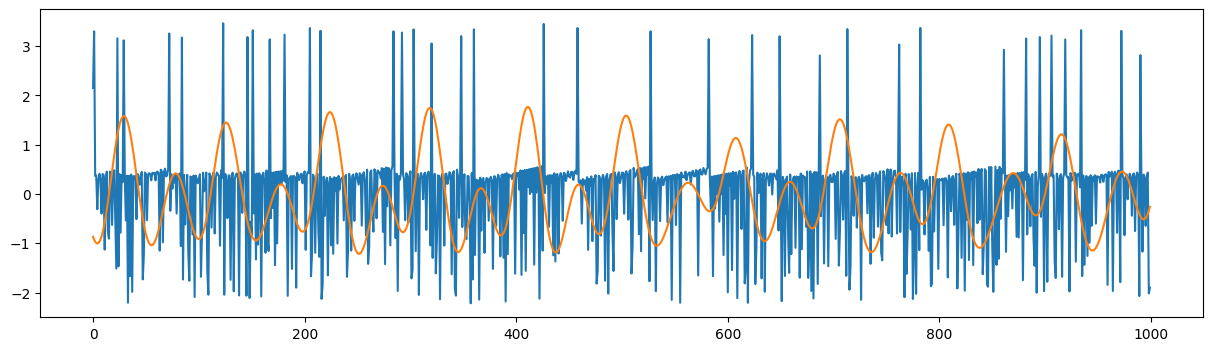

In [270]:
plt.figure(figsize=(15, 4))
plt.plot(temp1)
plt.plot(temp2*2)

In [271]:
# Band-pass filter design
def bandpass_filter(data, lowcut=0.7, highcut=2.5, fs=100, order=4):
    """
    Apply a band-pass filter to the data.

    Parameters:
        data (array): Input signal.
        lowcut (float): Low cutoff frequency (Hz).
        highcut (float): High cutoff frequency (Hz).
        fs (float): Sampling frequency (Hz).
        order (int): Filter order.

    Returns:
        filtered_data (array): Filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")  # Band-pass filter
    filtered_data = filtfilt(b, a, data)  # Apply filter with zero phase distortion
    return filtered_data



    # Apply band-pass filter



In [272]:
from scipy.signal import butter, filtfilt
filtered_recons=bandpass_filter(temp1)
filtered_gt=bandpass_filter(temp2)
#filtered_gt=filtered_gt.squeeze(0)

Text(0.5, 1.0, 'Filtered ECG Signal')

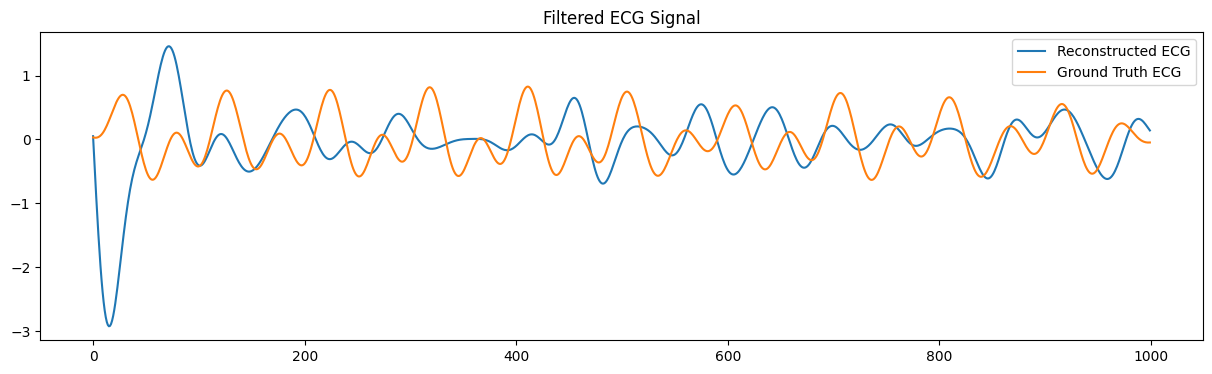

In [273]:
plt.figure(figsize=(15, 4))
#plt.subplot(1,1,1)

plt.plot(filtered_recons*2)
#plt.subplot(2,1,2)
plt.plot(filtered_gt)
plt.legend(["Reconstructed ECG", "Ground Truth ECG"])
plt.title("Filtered ECG Signal")

In [274]:
np.corrcoef(filtered_recons, filtered_gt)

array([[ 1.        , -0.12602483],
       [-0.12602483,  1.        ]])